In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

# Understanding recurrent neural networks

This notebook contains the code samples found in Chapter 6, Section 2 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

---

[...]

## A first recurrent layer in Keras

The process we just naively implemented in Numpy corresponds to an actual Keras layer: the `SimpleRNN` layer:


In [1]:
from keras.layers import SimpleRNN

Using TensorFlow backend.


There is just one minor difference: `SimpleRNN` processes batches of sequences, like all other Keras layers, not just a single sequence like 
in our Numpy example. This means that it takes inputs of shape `(batch_size, timesteps, input_features)`, rather than `(timesteps, 
input_features)`.

Like all recurrent layers in Keras, `SimpleRNN` can be run in two different modes: it can return either the full sequences of successive 
outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`), or it can return only the last output for each 
input sequence (a 2D tensor of shape `(batch_size, output_features)`). These two modes are controlled by the `return_sequences` constructor 
argument. Let's take a look at an example:

In [2]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

W0803 22:10:47.424054 140058478417728 deprecation_wrapper.py:119] From /data/cenvs/tftest/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0803 22:10:47.495441 140058478417728 deprecation_wrapper.py:119] From /data/cenvs/tftest/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0803 22:10:47.497233 140058478417728 deprecation_wrapper.py:119] From /data/cenvs/tftest/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [3]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


It is sometimes useful to stack several recurrent layers one after the other in order to increase the representational power of a network. 
In such a setup, you have to get all intermediate layers to return full sequences:

In [4]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # This last layer only returns the last outputs.
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


Now let's try to use such a model on the IMDB movie review classification problem. First, let's preprocess the data:

In [5]:
from keras.datasets import imdb
from keras.preprocessing import sequence
import numpy as np

max_features = 10000  # number of words to consider as features
maxlen = 500  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print('Loading data...')

# save np.load
np_load_old = np.load
# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# Load the data as lists of integers.
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)

np.load = np_load_old

print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


Let's train a simple recurrent network using an `Embedding` layer and a `SimpleRNN` layer:

In [6]:
from keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

W0803 22:11:26.421135 140058478417728 deprecation_wrapper.py:119] From /data/cenvs/tftest/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0803 22:11:26.432431 140058478417728 deprecation_wrapper.py:119] From /data/cenvs/tftest/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0803 22:11:26.435795 140058478417728 deprecation.py:323] From /data/cenvs/tftest/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0803 22:11:26.677671 140058478417728 deprecation_wrapper.py:119] From /data/cenvs/tftest/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The nam

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 17s 860us/step - loss: 0.6423 - acc: 0.6150 - val_loss: 0.5160 - val_acc: 0.7602
Epoch 2/10
20000/20000 [==============================] - 15s 729us/step - loss: 0.4219 - acc: 0.8181 - val_loss: 0.3768 - val_acc: 0.8424
Epoch 3/10
20000/20000 [==============================] - 15s 741us/step - loss: 0.3034 - acc: 0.8791 - val_loss: 0.3418 - val_acc: 0.8484
Epoch 4/10
20000/20000 [==============================] - 15s 734us/step - loss: 0.2452 - acc: 0.9052 - val_loss: 0.4001 - val_acc: 0.8486
Epoch 5/10
20000/20000 [==============================] - 15s 739us/step - loss: 0.2160 - acc: 0.9192 - val_loss: 0.4607 - val_acc: 0.8422
Epoch 6/10
20000/20000 [==============================] - 15s 735us/step - loss: 0.1610 - acc: 0.9424 - val_loss: 0.3413 - val_acc: 0.8724
Epoch 7/10
20000/20000 [==============================] - 15s 738us/step - loss: 0.1235 - acc: 0.9587 - val_loss: 0.3

Let's display the training and validation loss and accuracy:

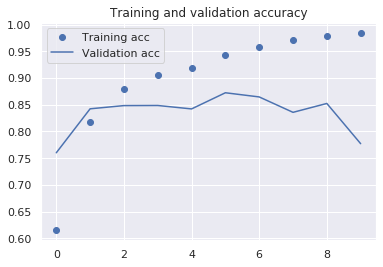

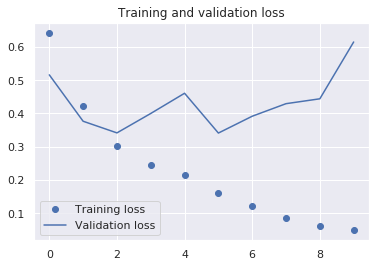

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns ; sns.set()

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

As a reminder, in chapter 3, our very first naive approach to this very dataset got us to 88% test accuracy. Unfortunately, our small 
recurrent network doesn't perform very well at all compared to this baseline (only up to 85% validation accuracy). Part of the problem is 
that our inputs only consider the first 500 words rather the full sequences -- 
hence our RNN has access to less information than our earlier baseline model. The remainder of the problem is simply that `SimpleRNN` isn't very good at processing long sequences, like text. Other types of recurrent layers perform much better. Let's take a look at some 
more advanced layers.

[...]

## A concrete LSTM example in Keras

Now let's switch to more practical concerns: we will set up a model using a LSTM layer and train it on the IMDB data. Here's the network, 
similar to the one with `SimpleRNN` that we just presented. We only specify the output dimensionality of the LSTM layer, and leave every 
other argument (there are lots) to the Keras defaults. Keras has good defaults, and things will almost always "just work" without you 
having to spend time tuning parameters by hand.

In [9]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 66s 3ms/step - loss: 0.5132 - acc: 0.7602 - val_loss: 0.3946 - val_acc: 0.8234
Epoch 2/10
20000/20000 [==============================] - 66s 3ms/step - loss: 0.2925 - acc: 0.8874 - val_loss: 0.3404 - val_acc: 0.8510
Epoch 3/10
20000/20000 [==============================] - 67s 3ms/step - loss: 0.2299 - acc: 0.9116 - val_loss: 0.3067 - val_acc: 0.8842
Epoch 4/10
20000/20000 [==============================] - 68s 3ms/step - loss: 0.1905 - acc: 0.9293 - val_loss: 0.3820 - val_acc: 0.8450
Epoch 5/10
20000/20000 [==============================] - 67s 3ms/step - loss: 0.1726 - acc: 0.9378 - val_loss: 0.3434 - val_acc: 0.8632
Epoch 6/10
20000/20000 [==============================] - 65s 3ms/step - loss: 0.1530 - acc: 0.9441 - val_loss: 0.4126 - val_acc: 0.8636
Epoch 7/10
20000/20000 [==============================] - 66s 3ms/step - loss: 0.1439 - acc: 0.9487 - val_loss: 0.4527 - val_acc:

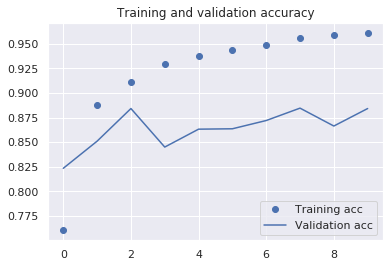

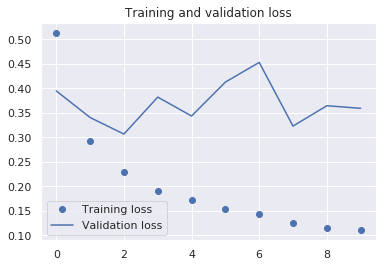

In [10]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()